<a href="https://colab.research.google.com/github/hemanth346/eva4/blob/master/S9/Q9_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from datetime import datetime 
print("Current Date/Time: ", datetime.now())


Current Date/Time:  2020-03-17 18:16:50.186878


In [1]:
!pip install torchsummary

In [2]:
!git clone https://github.com/hemanth346/pytorch-wrapper.git || rm -r pytorch-wrapper && git clone https://github.com/hemanth346/pytorch-wrapper.git 

Cloning into 'pytorch-wrapper'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 63 (delta 28), reused 55 (delta 20), pack-reused 0
Unpacking objects: 100% (63/63), done.
fatal: destination path 'pytorch-wrapper' already exists and is not an empty directory.


In [3]:
!ls -l pytorch-wrapper/engine

total 44
-rw-r--r-- 1 root root 2093 Mar 17 19:41 data_loader.py
-rw-r--r-- 1 root root  427 Mar 17 19:41 __init__.py
-rw-r--r-- 1 root root 1067 Mar 17 19:41 learner.py
-rw-r--r-- 1 root root 7516 Mar 17 19:41 models.py
-rw-r--r-- 1 root root  645 Mar 17 19:41 plots.py
-rw-r--r-- 1 root root 3884 Mar 17 19:41 trainer.py
-rw-r--r-- 1 root root 1688 Mar 17 19:41 utils.py
-rw-r--r-- 1 root root   51 Mar 17 19:41 version.py
-rw-r--r-- 1 root root 5713 Mar 17 19:41 visualize.py


In [13]:
%%writefile pytorch-wrapper/QuizDNN.py

from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision


def conv_block(in_channels, out_channels, dropout=0, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, *args, **kwargs),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Dropout(dropout)
        )
    

class QuizConNet(nn.Module):
    def __init__(self):
        super(QuizConNet, self).__init__()

        x1_out = 32
        self.x2 = conv_block(in_channels=3, out_channels=x1_out, kernel_size=3, padding=1, bias=False)  
        self.x3 = conv_block(in_channels=35, out_channels=x1_out, kernel_size=3, padding=1, dropout=0.1,  bias=False)     
        # self.x3 = conv_block(in_channels=x1_out, out_channels=x1_out, kernel_size=3, padding=1, dropout=0.1,  bias=False)     
        self.x4 = nn.MaxPool2d(2, 2)

        x5_out = 128
        self.x5 = conv_block(in_channels=67, out_channels=x5_out, kernel_size=3, padding=1, bias=False)  
        self.x6 = conv_block(in_channels=67+x5_out, out_channels=x5_out, kernel_size=3, padding=1, dropout=0.1,  bias=False)     
        self.x7 = conv_block(in_channels=67+x5_out+x5_out, out_channels=x5_out, kernel_size=3, padding=1, dropout=0.1,  bias=False)     
        self.x8 = nn.MaxPool2d(2, 2)


        x9_out = 256
        self.x9 = conv_block(in_channels=384, out_channels=x9_out, kernel_size=3, padding=1, bias=False)  
        self.x10 = conv_block(in_channels=384+x9_out, out_channels=x9_out, kernel_size=3, padding=1, dropout=0.1,  bias=False)     
        self.x11 = conv_block(in_channels=384+x9_out+x9_out, out_channels=x9_out, kernel_size=3, padding=1, dropout=0.1,  bias=False)     

        self.x12 = nn.AvgPool2d(kernel_size=8)                                                                          
        self.x13 = nn.Conv2d(in_channels=x9_out, out_channels=10, kernel_size=1, bias=False)                              

    def forward(self, x1):
        
        # x1 = Input
        x2 = self.x2(x1)  # inp : 32x32x3 -> 32x32x32
        x3 = self.x3(torch.cat((x1, x2), dim=1))  # 32x32x(3+32) -> 32x32x32
        x4 = self.x4(torch.cat((x1, x2, x3), dim=1))  # 32x32x(3+32+32) -> 16x16x(3+32+32)

        x5 = self.x5(x4)  # 16x16x67 -> 16x16x128
        x6 = self.x6(torch.cat((x4, x5), dim=1)) # 16x16x(67+128) -> 16x16x128
        x7 = self.x7(torch.cat((x4, x5, x6), dim=1))  # 16x16x(67+128+128) -> 16x16x128
        x8 = self.x8(torch.cat((x5, x6, x7), dim=1))  # 16x16x(128*3) -> 8x8x384(128*3) 

        x9  = self.x9(x8)  # 8x8x384 -> 8x8x256
        x10 = self.x10(torch.cat((x8, x9), dim=1))  # 8x8x(384+256) -> 8x8x256
        x11 = self.x11(torch.cat((x8, x9, x10), dim=1))  # 8x8x(384+256+256) -> 8x8x256
        x12 = self.x12(x11)  # 8x8x256 -> 1x1x256
        x13 = self.x13(x12)  # 1x1x256 -> 1x1x10
        x = x13.view(-1, 10)
        return F.log_softmax(x)



class QuizAddNet(nn.Module):
    def __init__(self):
        super(QuizAddNet, self).__init__()

        x1_out = 3#32
        # self.x1 = conv_block(in_channels=3, out_channels=x1_out, kernel_size=3, padding=1, bias=False)  
        self.x2 = conv_block(in_channels=3, out_channels=x1_out, kernel_size=3, padding=1, bias=False)  
        self.x3 = conv_block(in_channels=x1_out, out_channels=x1_out, kernel_size=3, padding=1, dropout=0.1,  bias=False)     
        self.x4 = nn.MaxPool2d(2, 2)

        x5_out = 3 #64
        self.x5 = conv_block(in_channels=x1_out, out_channels=x5_out, kernel_size=3, padding=1, bias=False)  
        self.x6 = conv_block(in_channels=x5_out, out_channels=x5_out, kernel_size=3, padding=1, dropout=0.1,  bias=False)     
        self.x7 = conv_block(in_channels=x5_out, out_channels=x5_out, kernel_size=3, padding=1, dropout=0.1,  bias=False)     
        self.x8 = nn.MaxPool2d(2, 2)


        x9_out = 3#128
        x11_out = 3#256
        self.x9 = conv_block(in_channels=x5_out, out_channels=x9_out, kernel_size=3, padding=1, bias=False)  
        self.x10 = conv_block(in_channels=x9_out, out_channels=x9_out, kernel_size=3, padding=1, dropout=0.1,  bias=False)     
        self.x11 = conv_block(in_channels=x9_out, out_channels=x9_out, kernel_size=3, padding=1, dropout=0.1,  bias=False)     

        self.x12 = nn.AvgPool2d(kernel_size=8)                                                                          
        self.x13 = nn.Conv2d(in_channels=x11_out, out_channels=10, kernel_size=1, bias=False)                              

    def forward(self, x1):
        # x1 = Input
        x2 = self.x2(x1)
        x3 = self.x3(x1+x2) 
        x4 = self.x4(x1+x2+x3)

        x5 = self.x5(x4)
        x6 = self.x6(x4+x5)
        x7 = self.x7(x4+x5+x6) 
        x8 = self.x8(x5+x6+x7)

        x9  = self.x9(x8)
        x10 = self.x10(x8+x9)
        x11 = self.x11(x8+x9+x10) 
        x12 = self.x12(x11)
        x13 = self.x13(x12)
        x = x13.view(-1, 10)
        return F.log_softmax(x)


Overwriting pytorch-wrapper/QuizDNN.py


In [0]:
import sys  
import os
sys.path.insert(0, os.path.abspath('pytorch-wrapper'))

In [0]:
# autoreload module content
%load_ext autoreload
%autoreload 2

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms
import torch.nn.functional as F


In [0]:
import engine

In [0]:
from engine.data_loader import DataLoader
# from engine.models import ResNet, BasicBlock#, summary
from engine.learner import Learner

In [10]:
train_loader, test_loader = DataLoader.get_cifar10(batch_size=64, seed=18)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
!cp QuizDNN.py pytorch-wrapper/

In [0]:
from QuizDNN import QuizConNet

In [15]:
# !pip install torchsummary
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
Net = QuizConNet().to(device)
summary(Net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]          10,080
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 67, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]          77,184
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

/content/pytorch-wrapper/QuizDNN.py:63: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # self.x1 = conv_block(in_channels=3, out_channels=x1_out, kernel_size=3, padding=1, bias=False)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [0]:
model = Learner(Net, train_loader, test_loader, criterion, optimizer)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer horse   car plane   car


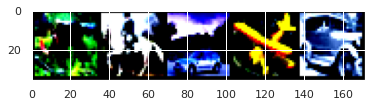

In [18]:
model.show_images(5)

In [19]:
model.run_epochs(20)


Epoch: 1


/content/pytorch-wrapper/QuizDNN.py:63: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # self.x1 = conv_block(in_channels=3, out_channels=x1_out, kernel_size=3, padding=1, bias=False)



Test Set: Accuracy: 62.99 (6299/10000) | Average Loss: 1.04892

Epoch: 2



Test Set: Accuracy: 61.20 (6120/10000) | Average Loss: 1.08991

Epoch: 3



Test Set: Accuracy: 60.83 (6083/10000) | Average Loss: 1.12437

Epoch: 4



Test Set: Accuracy: 75.49 (7549/10000) | Average Loss: 0.71181

Epoch: 5



Test Set: Accuracy: 79.35 (7935/10000) | Average Loss: 0.57663

Epoch: 6



Test Set: Accuracy: 79.66 (7966/10000) | Average Loss: 0.60000

Epoch: 7



Test Set: Accuracy: 73.32 (7332/10000) | Average Loss: 0.84472

Epoch: 8



Test Set: Accuracy: 82.60 (8260/10000) | Average Loss: 0.51140

Epoch: 9



Test Set: Accuracy: 83.61 (8361/10000) | Average Loss: 0.49427

Epoch: 10



Test Set: Accuracy: 83.53 (8353/10000) | Average Loss: 0.51341

Epoch: 11



Test Set: Accuracy: 79.60 (7960/10000) | Average Loss: 0.66514

Epoch: 12



Test Set: Accuracy: 77.60 (7760/10000) | Average Loss: 0.77055

Epoch: 13


KeyboardInterrupt: ignored

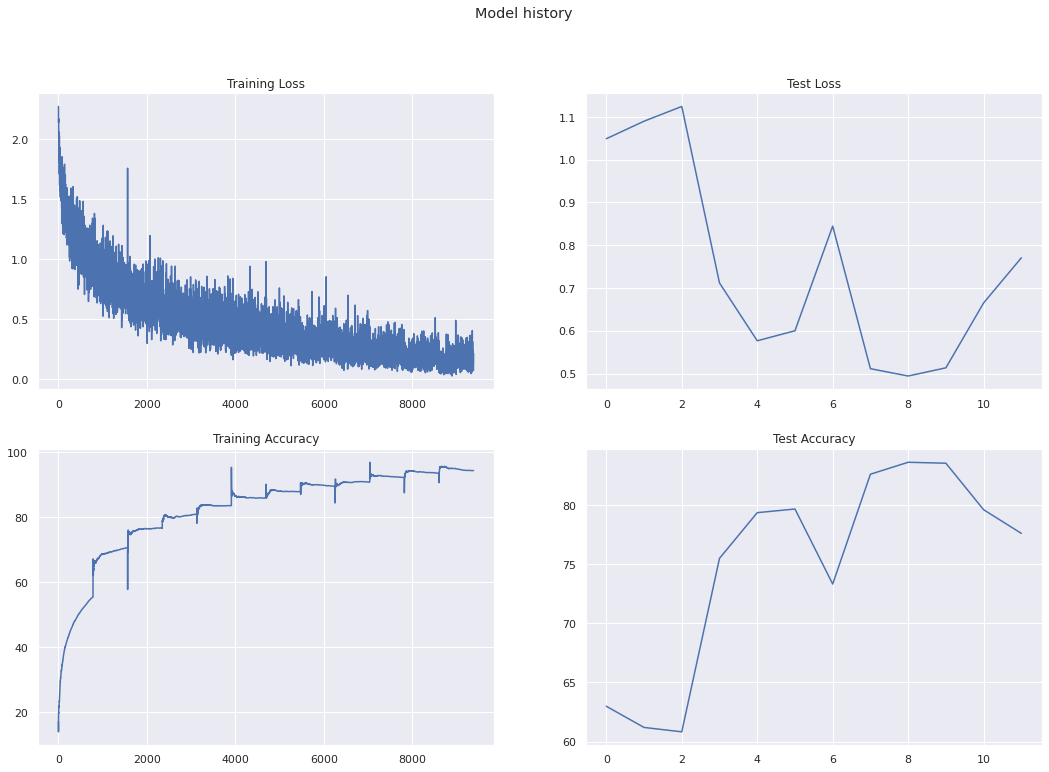

In [20]:
model.show_history()

In [21]:
model.classwise_accuracy()

/content/pytorch-wrapper/QuizDNN.py:63: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # self.x1 = conv_block(in_channels=3, out_channels=x1_out, kernel_size=3, padding=1, bias=False)


Accuracy of plane      : 81.43%
Accuracy of car        : 90.48%
Accuracy of bird       : 74.55%
Accuracy of cat        : 75.38%
Accuracy of deer       : 82.54%
Accuracy of dog        : 86.36%
Accuracy of frog       : 86.44%
Accuracy of horse      : 87.27%
Accuracy of ship       : 93.06%
Accuracy of truck      : 88.33%


/content/pytorch-wrapper/QuizDNN.py:63: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # self.x1 = conv_block(in_channels=3, out_channels=x1_out, kernel_size=3, padding=1, bias=False)


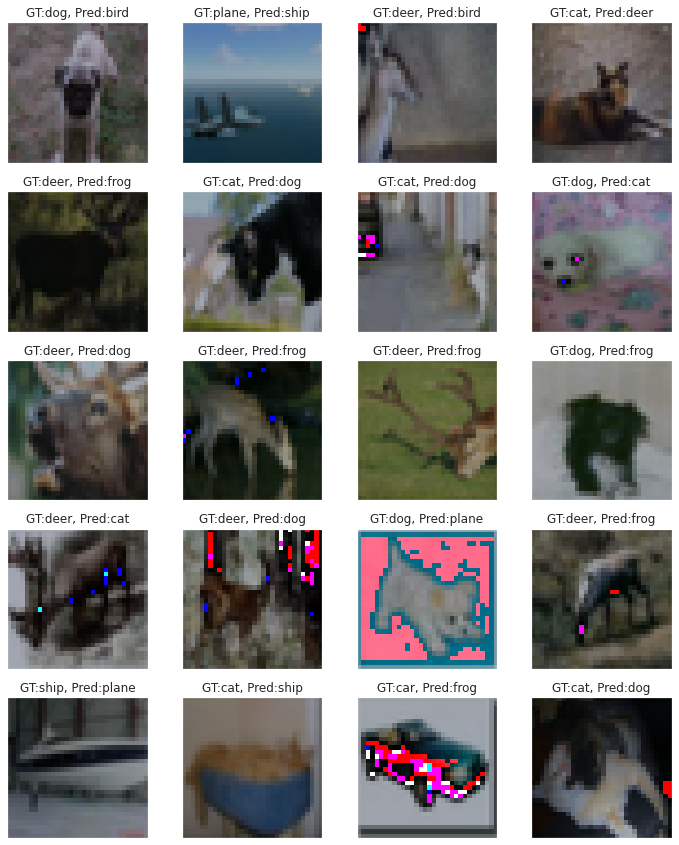

In [22]:
model.plot_misclassified()